In [1]:
# !pip install segmentation_models --user
# !pip install albumentations --user

In [1]:
import os
import cv2

import pandas as pd
import numpy as np

from torch.utils.data import Dataset

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
DATA_DIR = '../../data/dataset/train/'

IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')

FOLDS_CSV = os.path.join(DATA_DIR, 'folds.csv')
OOF = 1

In [5]:
CHECKPOINTS_DIR = '../../checkpoints/exp-4-oof-1'
os.makedirs(CHECKPOINTS_DIR)

### Dataset

In [6]:
def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def read_mask(path):
    return cv2.imread(path, 0).squeeze() / 255



class BuildingsDataset(Dataset):
    
    def __init__(self, ids, images_dir, masks_dir, transform=None):
        self.ids = ids
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        print('Reading images...')
        self.images = {id: read_image(os.path.join(images_dir, id)) for id in ids}
        
        print('Reading masks...')
        self.masks = {id: read_mask(os.path.join(masks_dir, id)) for id in ids}
        
    def __getitem__(self, i):
        
        id = self.ids[i]
        
        sample = {
            'image': self.images[id],
            'mask': self.masks[id],
        }
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample
        
    def __len__(self):
        return len(self.ids)

### Augmentation

In [7]:
import albumentations as alb

In [8]:
train_transfroms = [
    
    alb.RandomCrop(600, 600),
    
    alb.Flip(p=0.75),
    alb.Transpose(p=0.5),
    alb.RandomRotate90(p=0.5),
    
    alb.ShiftScaleRotate(shift_limit=0, rotate_limit=15, scale_limit=0.1, p=0.3),
    
    alb.CenterCrop(512, 512),
]

valid_transfroms = [
    
    alb.CenterCrop(5120, 5120)
]

train_aug = alb.Compose(train_transfroms)
valid_aug = alb.Compose(valid_transfroms)

### Transformations

In [9]:
import sys
sys.path.append('..')

In [10]:
from utils.datasets import make_transform

In [11]:
train_transform = make_transform(augmenter=train_aug)
valid_transform = make_transform(augmenter=valid_aug)

### Lodaing data

In [12]:
folds_df = pd.read_csv(FOLDS_CSV)

In [13]:
train_ids = [id + '.png' for id in folds_df[folds_df.fold != OOF].ImageId.values]
valid_ids = [id + '.png' for id in folds_df[folds_df.fold == OOF].ImageId.values]

print('Train', train_ids)
print('Valid', valid_ids)

Train ['AZ74029PBGFI0291.png', 'SQ77SFLTIREZWKAX.png', 'YTS6DUZYSW5KADN1.png', 'T4ZUFU91883CRMQ3.png', '8B7JP60TYSMLOTJO.png', 'LJJ5AQ6GYW6L2M8D.png', 'FOCNEZJJ9UP6IPIC.png']
Valid ['E60M2WMELMJVAPBB.png', 'E1QZENNLNLCXBKPN.png', 'A14OK5A65AR5AOST.png']


In [14]:
train_dataset = BuildingsDataset(train_ids, IMAGES_DIR, MASKS_DIR, transform=train_transform)
valid_dataset = BuildingsDataset(valid_ids, IMAGES_DIR, MASKS_DIR, transform=valid_transform)

Reading images...
Reading masks...
Reading images...
Reading masks...


### Visualization

In [15]:
import matplotlib.pyplot as plt

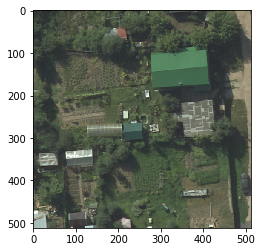

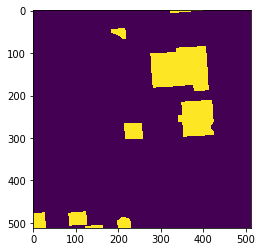

In [16]:
sample = train_dataset[0]

image = sample['image']
mask = sample['mask']

plt.imshow(image)
plt.show()
plt.imshow(mask.squeeze())
plt.show()

### Generators

In [17]:
import keras_backend
from keras_backend.generators import segmentation_generator

from torch.utils.data import WeightedRandomSampler

In [18]:
train_sampler = WeightedRandomSampler(
    weights=[1] * len(train_dataset),
    num_samples = 100000,
)

In [19]:
train_gen = segmentation_generator(train_dataset, batch_size=10, sampler=train_sampler)
valid_gen = segmentation_generator(valid_dataset, batch_size=1)

### Building network

In [20]:
from keras.models import Model
from keras import layers
from keras.optimizers import Adam

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

from keras_backend.losses import bce_jaccard_loss
from keras_backend.metrics import custom_f_score

Using TensorFlow backend.


In [21]:
model = Unet('densenet121')

### Callbacks

In [22]:
from keras.callbacks import ModelCheckpoint, TensorBoard

In [23]:
callbacks = [
    
    ModelCheckpoint(
        os.path.join(CHECKPOINTS_DIR, 'ep_{epoch}-score_{val_score:.5}.h5'), 
        monitor='val_score', 
        save_best_only=True,
        verbose=True,
        mode='max'
    ),

]

### Compilation

In [24]:
optimizer = Adam(1e-4)

loss = bce_jaccard_loss

f1_score = custom_f_score(beta=1)
f2_score = custom_f_score(beta=2)
                          
metrics = [f1_score, f2_score]

In [ ]:
model.compile(optimizer, loss, metrics)

### Traininig

In [ ]:
model.fit_generator(
    train_gen, 
    steps_per_epoch=100, 
    validation_data=valid_gen, 
    validation_steps=3, 
    initial_epoch=0,
    epochs=50, 
    callbacks=callbacks,
)

Epoch 1/50
100/100 [==============================] - 85s 845ms/step - loss: 0.8510 - score: 0.5503 - score_1: 0.6547 - val_loss: 0.7333 - val_score: 0.6661 - val_score_1: 0.8030

Epoch 00001: val_score improved from -inf to 0.66613, saving model to ../../checkpoints/exp-4-oof-1/ep_1-score_0.66613.h5
Epoch 2/50
100/100 [==============================] - 56s 563ms/step - loss: 0.5498 - score: 0.7198 - score_1: 0.7938 - val_loss: 0.5513 - val_score: 0.7527 - val_score_1: 0.8501

Epoch 00002: val_score improved from 0.66613 to 0.75270, saving model to ../../checkpoints/exp-4-oof-1/ep_2-score_0.7527.h5
Epoch 3/50
100/100 [==============================] - 56s 565ms/step - loss: 0.4474 - score: 0.7781 - score_1: 0.8321 - val_loss: 0.4004 - val_score: 0.8201 - val_score_1: 0.8745

Epoch 00003: val_score improved from 0.75270 to 0.82013, saving model to ../../checkpoints/exp-4-oof-1/ep_3-score_0.82013.h5
Epoch 4/50
100/100 [==============================] - 56s 561ms/step - loss: 0.3738 - sco

### Visualization

In [ ]:
def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

In [ ]:
sample = valid_dataset[1]

image = sample['image']
mask = sample['mask']

pred = model.predict(image[None, ...])

In [ ]:
image_1 = add_mask(image, pred.squeeze())

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(image_1[::4, ::4])
plt.show()